In [1]:
# import necessary libraries
import pandas as pd 
import numpy
import matplotlib.pyplot as plt 
from pyspark.sql import SparkSession, dataframe
import plotly.express as px
from pyspark.sql import functions as F

geojson = px.data.gapminder()
# create sparksession
spark = SparkSession \
    .builder \
    .appName("CS531Task2") \
    .getOrCreate()

In [2]:
sc = spark.sparkContext

In [3]:
# Utility function to write query plans to a file
# you will be using this to understand how your queries are being processed
def write_explain(df: dataframe.DataFrame, output_path: str = "out2.txt"):
    from contextlib import redirect_stdout
    with open(output_path, "w") as f:
        with redirect_stdout(f):
            df.explain(extended=True)

In [ ]:
#Spark SQL based approach

#Read the dataset
sdf = spark.read.csv("../data/StateAndCountyData.csv", header=True)

#Trimming the spaces in column in State
sdf = sdf.withColumn("State", F.trim(sdf["State"]))

#Converting Value column from string to float
sdf = sdf.withColumn("Value", F.col("Value").cast("float"))

#Filtering rows according to variable code having 2011 year's grocery info
groceryStores2011 = sdf.select("State", "County", "Variable_Code", "Value").filter(sdf["Variable_Code"] == "GROCPTH11")

#Calculating avg value of stores for each State in 2011
stateWiseSum2011 = (groceryStores2011
                    .groupBy("State")
                    .agg((F.sum("Value") / F.countDistinct("County")).cast("float")
                         .alias("Grocery Stores per 1000 people in 2011"))
                   )

#Filtering rows having 2016 year's grocery info
groceryStores2016 = sdf.select("State", "County", "Variable_Code", "Value").filter(sdf["Variable_Code"] == "GROCPTH16")

#Calculating avg value of stores for each State in 2016
stateWiseSum2016 = (groceryStores2016
                    .groupBy("State")
                    .agg((F.sum("Value") / F.countDistinct("County")).cast("float")
                         .alias("Grocery Stores per 1000 people in 2016"))
                   )

#Joining the 2011 and 2016 dataframes
joined_df = stateWiseSum2016.join(stateWiseSum2011, 'State')

#SQL query to get the top 3 states with maximum positive difference between 2011 and 2016
joined_df.createOrReplaceTempView("grocery_stores")

query = """SELECT 
    *,
    (`Grocery Stores per 1000 people in 2016` - `Grocery Stores per 1000 people in 2011`) AS Change
FROM 
    grocery_stores
ORDER BY 
    Change DESC
LIMIT 3"""

# Execute the query
topStates = spark.sql(query)

In [5]:
# Show the result
topStates.show()

+-----+--------------------------------------+--------------------------------------+-----------+
|State|Grocery Stores per 1000 people in 2016|Grocery Stores per 1000 people in 2011|     Change|
+-----+--------------------------------------+--------------------------------------+-----------+
|   AK|                            0.72680545|                            0.69263047| 0.03417498|
|   CO|                             0.3942081|                             0.3689442|0.025263906|
|   MA|                            0.26548636|                            0.24436969|0.021116674|
+-----+--------------------------------------+--------------------------------------+-----------+



In [6]:
#Calculating time for Spark SQL

def sparkSQL():
    sdf = spark.read.csv("../data/StateAndCountyData.csv", header=True)
    sdf = sdf.withColumn("State", F.trim(sdf["State"]))
    sdf = sdf.withColumn("Value", F.col("Value").cast("float"))
    
    groceryStores2011 = sdf.select("State", "County", "Variable_Code", "Value").filter(sdf["Variable_Code"] == "GROCPTH11")
    stateWiseSum2011 = (groceryStores2011
                        .groupBy("State")
                        .agg((F.sum("Value") / F.countDistinct("County")).cast("float")
                             .alias("Grocery Stores per 1000 people in 2011"))
                       )

    
    groceryStores2016 = sdf.select("State", "County", "Variable_Code", "Value").filter(sdf["Variable_Code"] == "GROCPTH16")
    stateWiseSum2016 = (groceryStores2016
                        .groupBy("State")
                        .agg((F.sum("Value") / F.countDistinct("County")).cast("float")
                             .alias("Grocery Stores per 1000 people in 2016"))
                       )
    
    joined_df = stateWiseSum2016.join(stateWiseSum2011, 'State')
    
    joined_df.createOrReplaceTempView("grocery_stores")
    
    query = """SELECT 
        *,
        (`Grocery Stores per 1000 people in 2016` - `Grocery Stores per 1000 people in 2011`) AS Change
    FROM 
        grocery_stores
    ORDER BY 
        Change DESC
    LIMIT 3"""
    
    topStates = spark.sql(query)


# Time the function execution 5 times
%timeit -n 1 sparkSQL()

285 ms ± 44.4 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [ ]:
#Spark RDD based approach (Resilient Distributed Dataset)

#Read the dataset
sdf = spark.read.csv("../data/StateAndCountyData.csv", header=True)

#Convert spark dataframe to RDD
rdd = sdf.rdd

# Filter the RDD to have rows with 'GROCPTH11' or 'GROCPTH16'
filtered_rdd_2011_16 = rdd.filter(lambda row: row.Variable_Code == 'GROCPTH11' or row.Variable_Code == 'GROCPTH16')

# Map to key-value pairs (key: State:Varibale_Code, Value: (Value of stores, 1))
# Also keeping columns of State and Variable Code
mapped_rdd_2011_16 = filtered_rdd_2011_16.map(lambda row: (row.State+':'+row.Variable_Code, \
                                                               (float(row.Value), 1, row.State, row.Variable_Code)))

# Reduce by key to sum the values of stores and count the total counties in State
# Also keeping columns of State and Variable Code
reduced_rdd_2011_16 = mapped_rdd_2011_16.reduceByKey(lambda a, b: (a[0] + b[0], a[1] + b[1], a[2], a[3]))

# Calculate the average value of stores for each State
# Also keeping columns of State and Variable Code
final_res_rdd_2011_16 = reduced_rdd_2011_16.mapValues(lambda x: (x[0] / x[1] , x[2],x[3]))

# Map key:State to Value: Avg value of stores, Variable code.
# Sort by Variable code 
mapped_diff_rdd_2011_16 = final_res_rdd_2011_16.map(lambda row: (row[1][1],(row[1][2], row[1][0]))).sortBy(lambda r:r[1][0])

# Reduce by key to get diff between 2016-2011
# Sort by diff calculated and take top 3. Parallelized by sc.parallelize
reduced_diff_rdd_2011_16 = sc.parallelize(mapped_diff_rdd_2011_16.reduceByKey(lambda a,b: b[1]-a[1]).sortBy(lambda r: -r[1]).take(3))

# Preparing rdd of 2011 and 2016 actual avg store values to join with diff RDD
final_ordered = final_res_rdd_2011_16.map(lambda row: (row[1][1], (row[1][0],row[1][2])))
df_11 = final_ordered.filter(lambda row : row[1][1] == 'GROCPTH11')
df_16 = final_ordered.filter(lambda row : row[1][1] == 'GROCPTH16')

# Join diff rdd with actual 2016 and 2011 rdds
final_result = df_11.join(df_16).join(reduced_diff_rdd_2011_16).\
    map(lambda row: (row[0], row[1][0][0][0], row[1][0][1][0],row[1][1])).sortBy(lambda row: -row[3])

In [8]:
# Rename columns and display results
final_result.toDF().withColumnRenamed('_1', 'State').withColumnRenamed('_2', 'Grocery Stores per 1000 people in 2011'). \
    withColumnRenamed('_3', 'Grocery Stores per 1000 people in 2016').withColumnRenamed('_4', 'Change').show()

+-----+--------------------------------------+--------------------------------------+--------------------+
|State|Grocery Stores per 1000 people in 2011|Grocery Stores per 1000 people in 2016|              Change|
+-----+--------------------------------------+--------------------------------------+--------------------+
|   AK|                    0.6926304815862069|                    0.7268054810689656|0.034174999482758706|
|   CO|                   0.36894420426562513|                   0.39420811356249996| 0.02526390929687483|
|   MA|                   0.24436968442857143|                           0.265486355|0.021116670571428575|
+-----+--------------------------------------+--------------------------------------+--------------------+



In [ ]:
#Calculating time for Spark RDD (Resilient Distributed Dataset)
def sparkRDD():

    sdf = spark.read.csv("../data/StateAndCountyData.csv", header=True)
    #Converting data to RDD
    rdd = sdf.rdd

    filtered_rdd_2011_16 = rdd.filter(lambda row: row.Variable_Code == 'GROCPTH11' or row.Variable_Code == 'GROCPTH16')
    
    mapped_rdd_2011_16 = filtered_rdd_2011_16.map(lambda row: (row.State+':'+row.Variable_Code, \
                                                               (float(row.Value), 1, row.State, row.Variable_Code)))
    reduced_rdd_2011_16 = mapped_rdd_2011_16.reduceByKey(lambda a, b: (a[0] + b[0], a[1] + b[1], a[2], a[3]))
    final_res_rdd_2011_16 = reduced_rdd_2011_16.mapValues(lambda x: (x[0] / x[1] , x[2],x[3]))
    
    diff = sc.parallelize(final_res_rdd_2011_16.map(lambda row: (row[1][1],(row[1][2], row[1][0]))). \
                          sortBy(lambda r:r[1][0]).reduceByKey(lambda a,b: b[1]-a[1]). \
                          sortBy(lambda r: -r[1]).take(3))
    
    final_ordered = final_res_rdd_2011_16.map(lambda row: (row[1][1], (row[1][0],row[1][2])))
    df_11 = final_ordered.filter(lambda row : row[1][1] == 'GROCPTH11')
    df_16 = final_ordered.filter(lambda row : row[1][1] == 'GROCPTH16')
    
    final_result = df_11.join(df_16).join(diff).map(lambda row: (row[0], row[1][0][0][0], row[1][0][1][0],row[1][1]))
    
%timeit -n 1 sparkRDD()

<Axes: xlabel='State'>

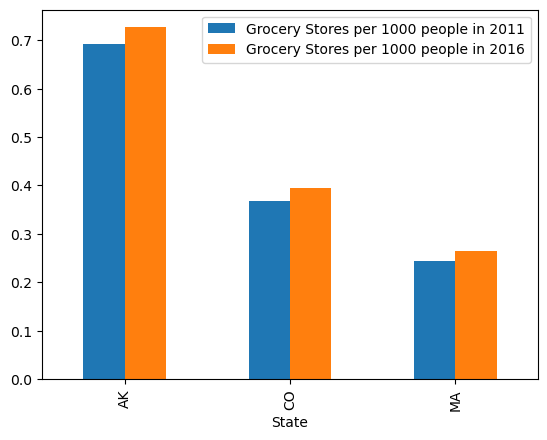

In [10]:
#Plotting bar graph

# Collect data from Spark DataFrame
top3States = topStates.collect()

#Converting to pandas dataframe
results_df = pd.DataFrame([(row.State, row["Grocery Stores per 1000 people in 2011"], row["Grocery Stores per 1000 people in 2016"]) for row in top3States],
                          columns=["State", "Grocery Stores per 1000 people in 2011", "Grocery Stores per 1000 people in 2016"])

# plotting graph 
results_df.plot(x="State", y=["Grocery Stores per 1000 people in 2011", "Grocery Stores per 1000 people in 2016"], kind="bar") 